In [7]:
import glob
import config
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [9]:
# training config:
epochs = 250
batch_size = 8

# define paths
covid_path = '/mnt/d/covid_classifier/dataset/covid_p'
noncovid_path = '/mnt/d/covid_classifier/dataset/covid_n'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob.glob(covid_path + '/*')
noncovid_files = glob.glob(noncovid_path + '/*')


150 310


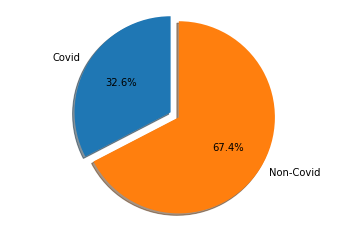

In [10]:
# 1st observation - Class Imbalance


print(len(covid_files), len(noncovid_files))

# Pie chart where the slices will be ordered and plotted counter-clockwise:
labels = 'Covid', 'Non-Covid'
sizes = [len(covid_files), len(noncovid_files)]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
# 2nd observation - Different Image sizes


A look at the dataset

In [14]:
from dataset import ImageFolder
#create train test split
train_ds = ImageFolder(root_dir="dataset/", transform = config.train_transforms)

class_weights=[1,2]
sample_weights = [0] * len(train_ds)
for idx, (data, label) in enumerate(train_ds):
    class_weight = class_weights[label]
    sample_weights[idx]=class_weights
# Sampler not used for the moment
#sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    
train_size = int(0.8 * len(train_ds))
test_size = len(train_ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_ds, [train_size, test_size])
train_dataset.transform = config.train_transforms
test_dataset.transform = config.val_transforms
print(len(train_dataset))
print(len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS,pin_memory=config.PIN_MEMORY, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS,pin_memory=config.PIN_MEMORY,shuffle=True)


368
92


In [ ]:
# 3rd observation (some are grayscaled and some are RGB)

Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1])


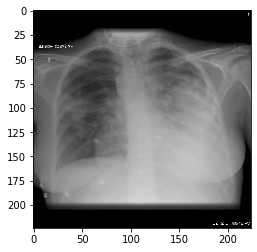

Label: 0


In [15]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]#.squeeze()
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import torchvision.models as models
import torch.nn.functional as F

# Transfer Learning Model for pneumonia
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        
        # Using VGG-16 as our transfer model
        self.prevmodel = models.vgg16(pretrained=True)

        # Not retraining the model. Instead, learning the output.
        # Freeze all layers we do not want the gradient to update.
        for param in self.prevmodel.parameters():
            param.require_grad = False

        # Delete last layer and add own final layer
        #self.prevmodel.features[-1] = nn.Linear(14, 2)
        num_ftrs = self.prevmodel.classifier[6].in_features
        self.prevmodel.classifier[6] = nn.Linear(num_ftrs, 2)

    # The forward operation for the NN. Backward is auto computed.
    def forward(self, x):
        x = self.prevmodel(x.float())
        x = F.log_softmax(x)
        return x

In [19]:
from train import train_model
model = TransferLearningModel().to(device)
class_weights=[1,2]
 
mloss = nn.CrossEntropyLoss()#weight= torch.tensor(class_weights))

dataloaders = {"train": train_loader, "val": val_loader}
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
m, validaccuracy = train_model(model, dataloaders, mloss, optimizer, device, num_epochs=10,is_inception=False)# decay=0.1, valid_interval=2, learning_rate=0.0001)

Epoch 0/9
----------


/home/jkabalar/anaconda3/envs/thesis/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/tmp/ipykernel_30240/2118418278.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
